In [4]:
import csv
import keras as kr
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2
import numpy as np
import sklearn
from keras.regularizers import l2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Data Collection

In [5]:
data_path = "../../../data/linux-sim/data/"

In [6]:
#Fetch the samples
lines = []
with open(data_path + "driving_log.csv") as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)
        
lines.pop(0)

['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']

In [7]:
sample1 = []
sample2 = []
sample3 = []
sample4 = []
#lines=lines[0:100]
#Get Center Images
for line in lines:
    sample1.append([line[0].split('/')[-1], float(line[3]), 0])
#Get Left Images
for line in lines:
    sample2.append([line[1].split('/')[-1], float(line[3])+0.2, 0])
#Get Right Images
for line in lines:
    sample3.append([line[2].split('/')[-1], float(line[3])-0.2, 0])
#Get Flip Images
for line in lines:
    sample4.append([line[0].split('/')[-1], -float(line[3]), 1])


## Train-Test split

In [8]:
BATCH_SIZE = 32

train_samples1, validation_samples1 = train_test_split(sample1, test_size=0.2)
train_samples2, validation_samples2 = train_test_split(sample2, test_size=0.2)
train_samples3, validation_samples3 = train_test_split(sample3, test_size=0.2)
train_samples4, validation_samples4 = train_test_split(sample4, test_size=0.2)

train_samples = train_samples1 + train_samples2 + train_samples3 + train_samples4
validation_samples = validation_samples1 + validation_samples2 + validation_samples3 + validation_samples4

## Helper functions for Crop, Preprocess and Generator 

In [9]:
def crop(img,x,y,h,w):
    return img[y:y+h, x:x+w, :]

def preprocess(image):
    image = crop(image,0,55,85,320)
    image = cv2.resize(image, (0,0), fx=0.3, fy=1)
    image = cv2.GaussianBlur(image, (5,5),0)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    return image

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = data_path + 'IMG/'+batch_sample[0].split('-')[-1]
                #print(name)
                image = preprocess(cv2.imread(name))
                if batch_sample[2] == 1:
                    image = np.fliplr(image)
                angle = batch_sample[1]
                images.append(image)
                angles.append(angle)
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

## Final Preprocessed image sample before feeding to Model

(85, 96, 3)


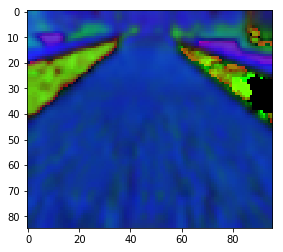

In [10]:
name = data_path + 'IMG/'+train_samples[0][0]
img = cv2.imread(name) #BGR
img = preprocess(img)
plt.imshow(img)
print(img.shape)

## Steering angle distrubution across Training and Test Data

(array([  1.10000000e+01,   3.00000000e+01,   3.07000000e+02,
          1.75100000e+03,   1.46360000e+04,   7.30100000e+03,
          1.44900000e+03,   2.11000000e+02,   1.30000000e+01,
          3.00000000e+00]),
 array([-1.1426954 , -0.90842586, -0.67415632, -0.43988678, -0.20561724,
         0.0286523 ,  0.26292184,  0.49719138,  0.73146092,  0.96573046,
         1.2       ]),
 <a list of 10 Patch objects>)

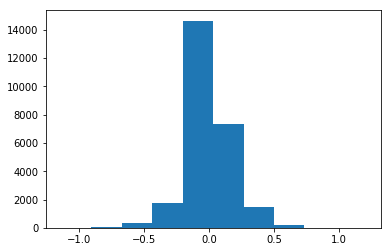

In [11]:
train_stearing = [angle[1] for angle in train_samples]
plt.hist(train_stearing)

(array([  2.00000000e+00,   4.00000000e+00,   7.80000000e+01,
          4.34000000e+02,   3.63500000e+03,   1.87000000e+03,
          3.55000000e+02,   4.50000000e+01,   8.00000000e+00,
          1.00000000e+00]),
 array([-1.1426954 , -0.90842586, -0.67415632, -0.43988678, -0.20561724,
         0.0286523 ,  0.26292184,  0.49719138,  0.73146092,  0.96573046,
         1.2       ]),
 <a list of 10 Patch objects>)

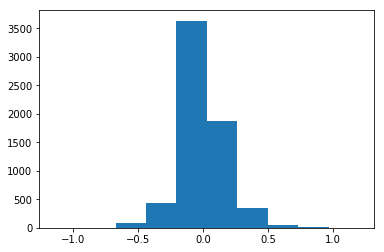

In [12]:
valid_steering = [angle[1] for angle in validation_samples]
plt.hist(valid_steering)

## Hyperparameter and setting Generator Function

In [13]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=BATCH_SIZE)
validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)

#fit_generator: the number of samples processed for each epoch is BATCH_SIZE * STEPS_PER_EPOCH.
STEPS_PER_EPOCH = len(train_samples) #int(len(train_samples)/BATCH_SIZE)
VALIDATION_STEPS = len(validation_samples) #int(len(validation_samples)/BATCH_SIZE)
EPOCHS = 5 #int(10 * (len(train_samples)/STEPS_PER_EPOCH))

## Model Architecture

In [14]:
#######################        Lenet MODEL START                  ##############################
################################################################################################
MODEL = "./model_lenet.h5"
CHECKPOINT = "./weights_lenet.h5"

model = kr.models.Sequential()

#Preprocess incoming data, centered around zero with small standard deviation 
model.add(kr.layers.Lambda(lambda x: x/127.5 - 1.0,  input_shape=(85, 96, 3), output_shape=(85, 96, 3)))

model.add(kr.layers.convolutional.Conv2D(activation="relu", kernel_size=(5, 5), filters=6, kernel_regularizer=l2(0.01), padding="valid"))
model.add(kr.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))

model.add(kr.layers.convolutional.Conv2D(activation="relu", kernel_size=(5, 5), filters=16, kernel_regularizer=l2(0.01), padding="valid"))
model.add(kr.layers.MaxPooling2D(pool_size=2, strides=2, padding='valid'))

model.add(kr.layers.Flatten())

model.add(kr.layers.Dense(120, activation='relu'))
model.add(kr.layers.Dropout(0.5))

model.add(kr.layers.Dense(84, activation='relu'))
model.add(kr.layers.Dropout(0.5))

model.add(kr.layers.Dense(1))

#### Change Cell Type to Code to build Nvidia CNN Model

MODEL = "../model_nvidia.h5"
CHECKPOINT = "../weights_nvidia.h5"

model = kr.models.Sequential()

#Preprocess incoming data, centered around zero with small standard deviation 
model.add(kr.layers.Lambda(lambda x: ((x-128)/128),  input_shape=(85, 96, 3), output_shape=(85, 96, 3)))

model.add(
    kr.layers.convolutional.Conv2D(
        activation="relu", kernel_size=(5, 5), kernel_regularizer=l2(0.01), strides=(2,2), filters=24))

model.add(
    kr.layers.convolutional.Conv2D(
        activation="relu", kernel_size=(5, 5), kernel_regularizer=l2(0.01), strides=(2,2), filters=36))

model.add(
    kr.layers.convolutional.Conv2D(
        activation="relu", kernel_size=(5, 5), kernel_regularizer=l2(0.01), strides=(2,2), filters=48))

model.add(
    kr.layers.convolutional.Conv2D(
        activation="relu", kernel_size=(3, 3), kernel_regularizer=l2(0.01), filters=64))

model.add(
    kr.layers.convolutional.Conv2D(
        activation="relu", kernel_size=(3, 3), kernel_regularizer=l2(0.01), filters=64))

model.add(kr.layers.Flatten())
model.add(kr.layers.Dense(1164, activation='relu'))
model.add(kr.layers.Dropout(0.5))

model.add(kr.layers.Dense(100, activation='relu'))
model.add(kr.layers.Dropout(0.5))

model.add(kr.layers.Dense(50, activation='relu'))
model.add(kr.layers.Dropout(0.5))

model.add(kr.layers.Dense(10, activation='relu'))
model.add(kr.layers.Dropout(0.5))

model.add(kr.layers.Dense(1))

## Select Optimizer

In [15]:
adam = kr.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

#sgd = kr.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile( loss = 'mse', optimizer = sgd, metrics=['accuracy'])

checkpoint = kr.callbacks.ModelCheckpoint(CHECKPOINT, monitor='val_loss', verbose=2, save_best_only=True, mode='min')

callbacks_list = [checkpoint]

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 85, 96, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 81, 92, 6)         456       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 46, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 42, 16)        2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 21, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               725880    
__________

## Print Hyperparameters

In [13]:
print("Training Samples: ", len(train_samples))
print("Validation Samples: ", len(validation_samples))
print()
print("BATCH_SIZE: ", BATCH_SIZE)
print("STEPS_PER_EPOCH: ", STEPS_PER_EPOCH)
print("VALIDATION_STEPS: ", VALIDATION_STEPS)
print("EPOCHS: ", EPOCHS)

Training Samples:  25712
Validation Samples:  6432

BATCH_SIZE:  32
STEPS_PER_EPOCH:  25712
VALIDATION_STEPS:  6432
EPOCHS:  5


## Training the Model

In [51]:
model.load_weights(CHECKPOINT)
history = model.fit_generator(train_generator,
                              validation_data=validation_generator, 
                              steps_per_epoch=STEPS_PER_EPOCH,
                              epochs=EPOCHS,
                              validation_steps=VALIDATION_STEPS,
                              callbacks=callbacks_list,
                              verbose=1
                             )
print(history.history.keys())
model.save(MODEL)
#DELIMITER = ","
#print("loss"+DELIMITER+"val_loss"+DELIMITER+"acc"+DELIMITER+"val_acc")
#for i in range(len(history.history['loss'])):
#    print(history.history['loss'][i],DELIMITER,history.history['val_loss'][i],DELIMITER,history.history['acc'][i],DELIMITER,history.history['val_acc'][i])

Training Samples:  836
Validation Samples:  212

BATCH_SIZE:  32
STEPS_PER_EPOCH:  836
VALIDATION_STEPS:  212
EPOCHS:  5
Epoch 1/5
836/836 [==============================] - 329s 394ms/step - loss: 0.0470 - acc: 0.3219 - val_loss: 0.0406 - val_acc: 0.3229

Epoch 00001: val_loss improved from inf to 0.04055, saving model to ./weights_lenet.h5
Epoch 2/5
836/836 [==============================] - 347s 415ms/step - loss: 0.0372 - acc: 0.3235 - val_loss: 0.0314 - val_acc: 0.3233

Epoch 00002: val_loss improved from 0.04055 to 0.03137, saving model to ./weights_lenet.h5
Epoch 3/5
836/836 [==============================] - 335s 401ms/step - loss: 0.0331 - acc: 0.3240 - val_loss: 0.0305 - val_acc: 0.3177

Epoch 00003: val_loss improved from 0.03137 to 0.03054, saving model to ./weights_lenet.h5
Epoch 4/5
836/836 [==============================] - 340s 407ms/step - loss: 0.0307 - acc: 0.3242 - val_loss: 0.0308 - val_acc: 0.3177

Epoch 00004: val_loss did not improve from 0.03054
Epoch 5/5
836/8

dict_keys(['val_loss', 'loss', 'val_acc', 'acc'])


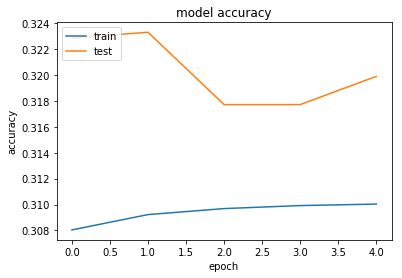

In [52]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

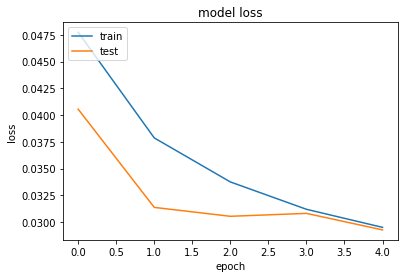

In [53]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')